## Libraries

In [ ]:
import cooler

from cooltools import insulation
import cooltools

import numpy as np
import pandas as pd

import bioframe

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
import bbi

import tad_common

from coolpuppy import coolpup
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
from matplotlib.colors import LogNorm, Normalize
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Get boundaries

In [ ]:
resolution = 10000
NPROC = 8

In [ ]:
windows = [50*resolution]
sample_names = {'Control' : 0, '12min': 12}

clr_ = [cooler.Cooler(f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t{sample}_q30.mcool::resolutions/{resolution}") for sample in sample_names.values()]

In [ ]:
# if not cached run this

insulation_table_ = [insulation(clr, windows, verbose=False, nproc = NPROC, ignore_diags = None) for clr in clr_]

accepted_range = 1
only_strong_base = True

switch_df = tad_common.boundary_switch(
    ins_df_list=insulation_table_, 
    sample_names=list(sample_names.keys()), 
    window=windows[0], 
    only_strong_base=only_strong_base, 
    accepted_range=accepted_range)

In [ ]:
# if cached run this

# run if cached already
insulation_table_ = [pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/boundaries/insulation_df_{sample_name}_{windows[0]}.tsv", sep="\t") for sample_name in sample_names.keys()]
import tad_common
accepted_range = 1
only_strong_base = True
switch_df = tad_common.boundary_switch(
    ins_df_list = insulation_table_, 
    sample_names = list(sample_names.keys()),
    window = windows[0], 
    only_strong_base = only_strong_base, 
    accepted_range = accepted_range)

In [ ]:
#test_comb =[('Control', '12min'),  ('12min', '30min'), ('30min', '60min')]
test_comb =[('Control', '12min')]

test_df = switch_df[switch_df.apply(lambda x: (x['sample1'], x['sample2']) in test_comb, axis=1)]

## BS change ~ Repair

In [ ]:
test_comb =[('Control', '12min')]

bs_rep_df = switch_df[switch_df.apply(lambda x: (x['sample1'], x['sample2']) in test_comb, axis=1)]

bs_rep_df = bs_rep_df[bs_rep_df['case'].isin(['Preserved'])].reset_index(inplace=False, drop=True)
bs_rep_df['bs_change'] = bs_rep_df.apply(lambda x: x['bs2'] - x['bs1'], axis=1)

bins = clr_[0].bins()[:]
idx = bs_rep_df['idx1']
merged_df = pd.concat([bs_rep_df, bins.iloc[idx, [0,1,2]].reset_index(inplace=False, drop=True)], axis=1)

stack_ups_ = prep_stackups(
    merged_df,
    nbins=1,
    flank=0,
)

In [ ]:
for k,v in stack_ups_.items():
    merged_df[k] = v.flatten().tolist()

merged_df.dropna(inplace=True)

In [ ]:
for k,v in stack_ups_.items():
    print(k, np.corrcoef(merged_df['bs_change'], merged_df[k])[0,1])

In [ ]:
sns.kdeplot(x=merged_df['bs_change'], y=merged_df['rep-eff-cpd'], cmap="Blues", shade=True, thresh=0)
# limit x y axis
plt.xlim(-0.60, 0.65)
plt.ylim(0.40, 2.1)

## Genes overlap

In [ ]:
# import gtf
gtf_path = "/cta/users/vkaya/refs/GRCh38.gtf"
genes = bioframe.read_table(gtf_path, schema='gtf').query('feature=="gene"')

# Define a function to extract key-value pairs from attributes
def parse_attributes(attribute_str):
    attributes = {}
    parts = attribute_str.split(';')
    for part in parts:
        key_value = part.strip().split(' "')
        if len(key_value) == 2:
            key, value = key_value
            attributes[key.strip()] = value.strip('"')
    return attributes

# Apply the extract_attributes function to the attributes column
genes['attributes'] = genes['attributes'].apply(parse_attributes)

# Create new columns for each attribute
genes_df = pd.concat([genes.drop(['attributes'], axis=1), genes['attributes'].apply(pd.Series)], axis=1)

# Update coord of gene start, based on strand
tss_parsed_df = genes_df.copy()
tss_parsed_df.loc[genes_df['strand'] == '+', 'end'] = genes_df['start'] + 1
tss_parsed_df.loc[genes_df['strand'] == '-', 'start'] = genes_df['end'] - 1
tss_parsed_df.start = tss_parsed_df.start.astype(int)
tss_parsed_df.end = tss_parsed_df.end.astype(int)


In [ ]:
n_flank = 1

# convert below code to function, not unique to lost_df

def overlap_boundaries_to_tss(b_df, tss_parsed_df, resolution, n_flank=1):
    bins_df = clr_[0].bins()[:]
    b_coords = bins_df.loc[b_df['idx1'], ['chrom', 'start', 'end']]
    b_coords.start = b_coords.start - (n_flank*resolution)
    b_coords.end = b_coords.end + (n_flank*resolution)
    df = bioframe.overlap(tss_parsed_df, b_coords, how='right')
    return df.dropna()

lost_df = test_df[test_df['case'] == 'Lost']
preserved_df = test_df[test_df['case'].isin(['Preserved', 'Shifted'])]

# get the background as all genes tss at stronng boundaries
t0_ins = insulation_table_[0]
t0_all_strong = t0_ins.loc[t0_ins['is_boundary_500000'] == True].iloc[:, 0:3]

t0_all_strong.start = t0_all_strong.start - (n_flank*resolution)
t0_all_strong.end = t0_all_strong.end + (n_flank*resolution)
bg_tss_df = bioframe.overlap(tss_parsed_df, t0_all_strong, how='right').dropna()
preserved_tss_df = overlap_boundaries_to_tss(preserved_df, tss_parsed_df, resolution, n_flank=n_flank)
lost_tss_df = overlap_boundaries_to_tss(lost_df, tss_parsed_df, resolution, n_flank=n_flank)

ensembl_gene_ids = preserved_tss_df.gene_id.apply(lambda x: x.split('.')[0]).values
# Convert Ensembl gene IDs to Entrez gene IDs
mg = mygene.MyGeneInfo()
results = mg.getgenes(ensembl_gene_ids, fields="symbol")
# Extract the Entrez gene IDs from the results
entrez_gene_ids = [result.get("symbol", None) for result in results]

In [ ]:
for i in pd.Series(entrez_gene_ids).dropna().values:
    print(i)

## Get expected

In [ ]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr_[0].chromnames)].reset_index(drop=True)

#hg38_arms = pd.read_csv("/cta/users/vkaya/hi-c/work/hela/notebooks/hg38_arms.csv", sep="\t")

In [ ]:
expected_ = [cooltools.expected_cis(
        clr=clr,
        view_df=hg38_arms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=NPROC,
        clr_weight_name='weight') for clr in clr_]

## Get bw data

In [ ]:
import bbi
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]
def get_mean_bw(bw, chrom_sizes):
    for chrom in chrom_sizes.index:
        start, end = 0, chrom_sizes.loc[chrom] // 10000 * 10000
        yield np.nanmean(bbi.fetch(bw, chrom, start, end, bins=chrom_sizes.loc[chrom] // 1000))

BWS = {
    'xr-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_real_over_sim_res1000.bw',
    'xr-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw',
    'ds-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_64_real_over_sim_res1000.bw',
    'ds-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_CPD_real_over_sim_res1000.bw',
    'rep-eff-64': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_rep_eff_res1000.bw',
    'rep-eff-cpd': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_rep_eff_res1000.bw',
    'ctcf': '/home/carlos/Desktop/manuscripts/notebooks/bws/ctcf.foi.bigWig',
    }

MEANS_BW = {}
for k in BWS:
    if k != 'ctcf':
        curr_mean = np.mean(list(get_mean_bw(BWS[k], chrom_sizes)))
        MEANS_BW[k] = curr_mean
        print(k, curr_mean)
    elif k == 'ctcf':
        MEANS_BW[k] = 1

In [ ]:
def prep_stackups(regions, nbins, flank):

    stackups = {k: bbi.stackup(v,
                        regions.chrom,
                        regions.start-flank,
                        regions.end+flank,
                        bins=nbins) / MEANS_BW[k] for k, v in BWS.items()}
    return stackups

In [35]:
flank = 500_000
nbins = (flank * 2 + 10_000) // 1000 # 1000 bp is bw files' resolution
#nbins /= 10 # smooth by 10
nbins = int(nbins)
bins = clr_[0].bins()[:]

In [109]:
idx_preserved = test_df.loc[(test_df['sample1'] == 'Control') & (test_df['sample2'] == '12min') & (test_df['case'].isin(['Preserved', 'Shifted']))].idx2

preserved_boundaries = bins.loc[idx_preserved]
stackups_preserved = prep_stackups(preserved_boundaries, nbins, flank)

idx_lost = test_df.loc[(test_df['sample1'] == 'Control') & (test_df['sample2'] == '12min') & (test_df['case'].isin(['Lost']))].idx1
lost_boundaries = bins.loc[idx_lost]
stackups_lost = prep_stackups(lost_boundaries, nbins, flank)

## Get Ins. Scores

In [110]:
nbins_flank = 50

def get_ins_scores(ins_df, idx, n_flank, tlog2=False):
    ins_scores = []
    arr_ = []
    for pos_idx in idx:
        start_idx = pos_idx - n_flank
        end_idx = pos_idx + n_flank + 1
        arr_.append(2 ** ins_df.iloc[start_idx:end_idx].log2_insulation_score_500000.values)
    
    if tlog2:
        return np.log2(np.nanmean(arr_, axis=0))
    else:
        return np.nanmean(arr_, axis=0)

ins_scores_preserved = [
    get_ins_scores(insulation_table_[0], idx_preserved, nbins_flank, tlog2=True),
    get_ins_scores(insulation_table_[1], idx_preserved, nbins_flank, tlog2=True),
]

ins_scores_lost = [
    get_ins_scores(insulation_table_[0], idx_lost, nbins_flank, tlog2=True),
    get_ins_scores(insulation_table_[1], idx_lost, nbins_flank, tlog2=True),
]

## Viz

In [111]:
pup_preserved_ = [coolpup.pileup(
    clr, 
    preserved_boundaries, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_preserved_ = divide_pups(pup_preserved_[1], pup_preserved_[0])

pup_lost_ = [coolpup.pileup(
    clr, 
    lost_boundaries, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_lost_ = divide_pups(pup_lost_[1], pup_lost_[0])

INFO:coolpuppy:('chr1_p', 'chr1_p'): 160
INFO:coolpuppy:('chr4_p', 'chr4_p'): 51
INFO:coolpuppy:('chr2_p', 'chr2_p'): 109
INFO:coolpuppy:('chr3_p', 'chr3_p'): 102
INFO:coolpuppy:('chr5_p', 'chr5_p'): 36
INFO:coolpuppy:('chr6_p', 'chr6_p'): 83
INFO:coolpuppy:('chr8_p', 'chr8_p'): 54
INFO:coolpuppy:('chr7_p', 'chr7_p'): 67
INFO:coolpuppy:('chr1_q', 'chr1_q'): 132
INFO:coolpuppy:('chr4_q', 'chr4_q'): 135
INFO:coolpuppy:('chr2_q', 'chr2_q'): 149
INFO:coolpuppy:('chr3_q', 'chr3_q'): 112
INFO:coolpuppy:('chr9_p', 'chr9_p'): 43
INFO:coolpuppy:('chr8_q', 'chr8_q'): 112
INFO:coolpuppy:('chr10_p', 'chr10_p'): 44
INFO:coolpuppy:('chr6_q', 'chr6_q'): 116
INFO:coolpuppy:('chr7_q', 'chr7_q'): 95
INFO:coolpuppy:('chr11_p', 'chr11_p'): 64
INFO:coolpuppy:('chr5_q', 'chr5_q'): 155
INFO:coolpuppy:('chr12_p', 'chr12_p'): 47
INFO:coolpuppy:('chr9_q', 'chr9_q'): 102
INFO:coolpuppy:('chr10_q', 'chr10_q'): 104
INFO:coolpuppy:('chr16_p', 'chr16_p'): 28
INFO:coolpuppy:('chr13_q', 'chr13_q'): 88
INFO:coolpuppy:(

In [112]:

bw_dict_to_plot_preserved = {
    'CPD': stackups_preserved['xr-cpd-over-sim'],
    '(6-4)PP': stackups_preserved['xr-64-over-sim'],
    # 'CPD': stackups_preserved['rep-eff-cpd'],
    # '(6-4)PP': stackups_preserved['rep-eff-64'],
}

bw_dict_to_plot_lost = {
    'CPD': stackups_lost['xr-cpd-over-sim'],
    '(6-4)PP': stackups_lost['xr-64-over-sim'],
    # 'CPD': stackups_lost['rep-eff-cpd'],
    # '(6-4)PP': stackups_lost['rep-eff-64'],
}

bw_dict_to_plot_preserved_ds = {
    'CPD': stackups_preserved['ds-cpd-over-sim'],
    '(6-4)PP': stackups_preserved['ds-64-over-sim'],

}

bw_dict_to_plot_lost_ds = {
    'CPD': stackups_lost['ds-cpd-over-sim'],
    '(6-4)PP': stackups_lost['ds-64-over-sim'],

}

bw_dict_to_plot_preserved_ctcf = {
    'CTCF': stackups_preserved['ctcf'],

}

bw_dict_to_plot_lost_ctcf = {
    'CTCF': stackups_lost['ctcf'],
}


def make_bw_df(bw_dict, sigma):
    bw_data = {
    'n': [],
    'val': [],
    'name': []
    }

    labels = list(range(len(bw_dict.keys())))
    for i, k in enumerate(bw_dict.keys()):
        val = np.nanmean(bw_dict[k], axis=0)
        val = gaussian_filter1d(val, sigma = sigma) if sigma is not None else val
        bw_data['n'].extend(np.arange(len(val)).tolist())
        bw_data['val'].extend(val)
        #bw_data['name'].extend([labels[i]] * len(val))
        bw_data['name'].extend([k] * len(val))

    bw_df = pd.DataFrame(bw_data)
    return bw_df


sigma = 1
# preserved bw
bw_df_preserved_repair_eff = make_bw_df(bw_dict_to_plot_preserved, sigma=sigma)
bw_df_preserved_ds = make_bw_df(bw_dict_to_plot_preserved_ds, sigma=sigma)
bw_df_preserved_ctcf = make_bw_df(bw_dict_to_plot_preserved_ctcf, sigma=sigma)
# lost bw
bw_df_lost_repair_eff = make_bw_df(bw_dict_to_plot_lost, sigma=sigma)
bw_df_lost_ds = make_bw_df(bw_dict_to_plot_lost_ds, sigma=sigma)
bw_df_lost_ctcf = make_bw_df(bw_dict_to_plot_lost_ctcf, sigma=sigma)

/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_14708/2085029595.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4,0].set_yticklabels(yticks)


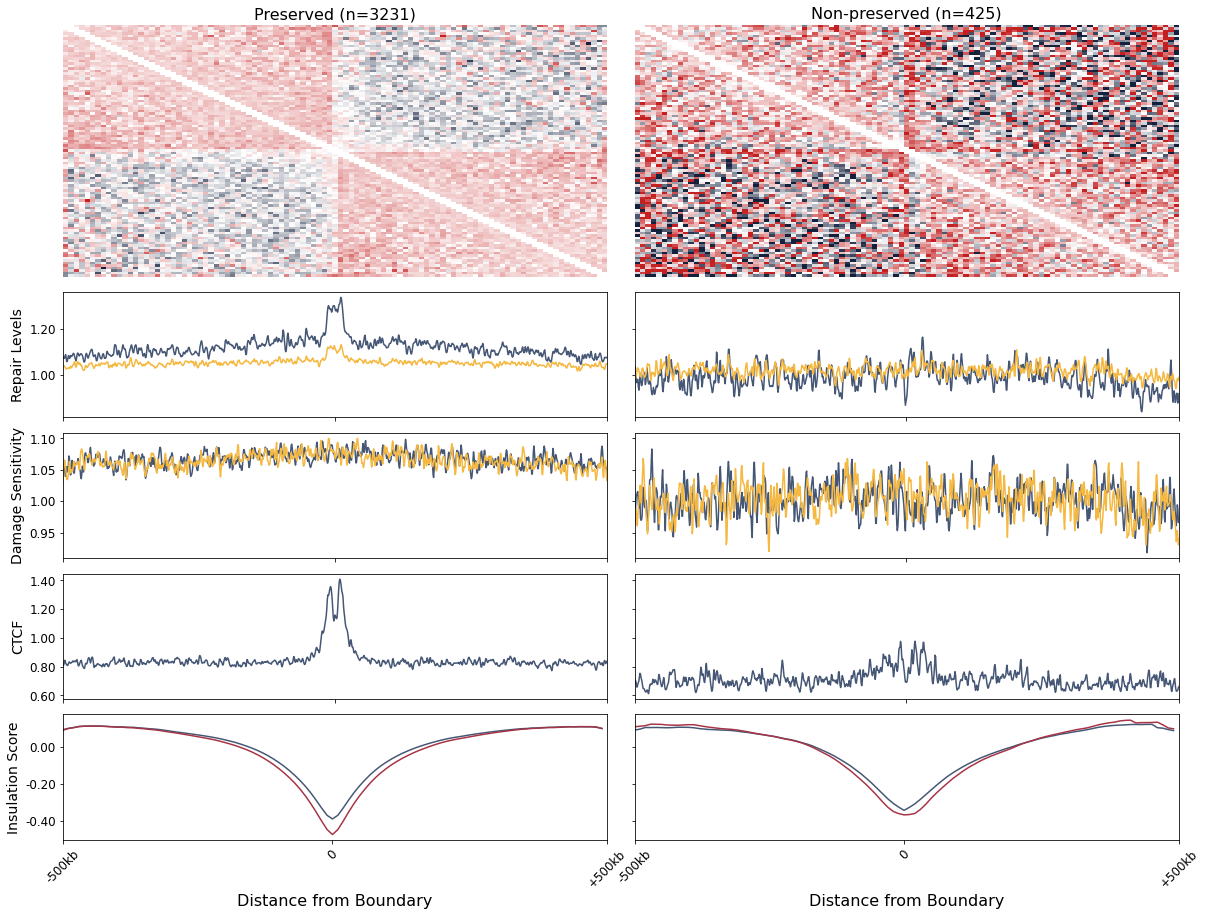

In [115]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)


height_ratios = np.array([1, .5, .5, .5, .5])
width_ratios = np.array([1, 1])
fig, ax = plt.subplots(
    nrows=5, 
    ncols=2, 
    sharex='row', 
    sharey='row', 
    figsize=(20, 15), 
    gridspec_kw={'height_ratios':height_ratios,
                 'width_ratios':width_ratios,
                 'hspace':0.10,
                 'wspace':0.05})

#norm colors to preserved data
vmin, vmax = plotpup.get_min_max(
            pup_divide_preserved_.data[0], 
            sym=False, 
            scale="log",
            vmin=None,
            vmax=None,
            )

norm = LogNorm(vmin=vmin, vmax=vmax)

hm = sns.heatmap(
    pup_divide_preserved_.data[0], 
    ax=ax[0,0], 
    cmap=cmp, 
    norm=norm, 
    cbar=False, 
    xticklabels=False, 
    yticklabels=False)
hm.set_title(f'Preserved (n={len(preserved_boundaries)})', fontsize=16)

hm = sns.heatmap(
    pup_divide_lost_.data[0], 
    ax=ax[0,1], 
    cmap=cmp, 
    norm=norm, 
    cbar=False, 
    xticklabels=False, 
    yticklabels=False)
hm.set_title(f'Non-preserved (n={len(lost_boundaries)})', fontsize=16)

def plot_bw(bw_df, palette, ax=None, ylabel=None, armlabel=250, xlabel=False):
    l = sns.lineplot(data=bw_df, x='n', y='val', hue='name', ax=ax, legend=False, palette=palette)
    end = bw_df['n'].max()
    l.set_xticks([0, end//2, end])
    if xlabel:
        l.set_xticklabels([f"-{armlabel}kb", 0, f"+{armlabel}kb"])
        l.set_xlabel('Distance from Boundary', fontsize=16)
    else:
        # remove xticks, xlabel
        l.set_xticklabels([])
        l.set_xlabel('')
    l.set_ylabel(ylabel, fontsize=14)
    yticks = [f"{i:.2f}" for i in l.get_yticks()]
    l.set_yticklabels(yticks)
    #increase tick size
    l.tick_params(axis='both', which='major', labelsize=12)

    
plot_bw(bw_df_preserved_repair_eff, ax=ax[1,0], ylabel='Repair Levels', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(bw_df_lost_repair_eff, ax=ax[1,1], ylabel='Repair Levels', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[1,0].margins(x=0)
ax[1,1].margins(x=0)
plot_bw(bw_df_preserved_ds, ax=ax[2,0], ylabel='Damage Sensitivity', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(bw_df_lost_ds, ax=ax[2,1], ylabel='Damage Sensitivity', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[2,0].margins(x=0)
ax[2,1].margins(x=0)
#ax[2,0].set_yticks([1.0, 1.02, 1.04, 1.06])
#ax[2,1].set_yticks([1.0, 1.02, 1.04, 1.06])

plot_bw(bw_df_preserved_ctcf, ax=ax[3,0], ylabel='CTCF', palette=['#465775'], armlabel=flank//1000)
plot_bw(bw_df_lost_ctcf, ax=ax[3,1], ylabel='CTCF', palette=['#465775'], armlabel=flank//1000)
ax[3,0].margins(x=0)
ax[3,1].margins(x=0)

sns.lineplot(x= np.arange(-50, 51), y=ins_scores_preserved[0], ax=ax[4,0], color='#465775')
sns.lineplot(x= np.arange(-50, 51), y=ins_scores_preserved[1], ax=ax[4,0], color='#A63446')
sns.lineplot(x= np.arange(-50, 51), y=ins_scores_lost[0], ax=ax[4,1], color='#465775')
sns.lineplot(x= np.arange(-50, 51), y=ins_scores_lost[1], ax=ax[4,1], color='#A63446')
ax[4,0].margins(x=0)
ax[4,1].margins(x=0)
ax[4,0].set_ylabel("Insulation Score", fontsize=14)

yticks = [f"{i:.2f}" for i in ax[4,0].get_yticks()]
ax[4,0].set_yticklabels(yticks)
ax[4,0].tick_params(axis='both', which='major', labelsize=12)
ax[4,0].set_xticks([-50, 0, 51])
ax[4,0].set_xticklabels([f"-{500}kb", 0, f"+{500}kb"])
ax[4,0].set_xlabel('Distance from Boundary', fontsize=16)

yticks = [f"{i:.2f}" for i in ax[4,1].get_yticks()]
ax[4,1].set_yticklabels(yticks)
ax[4,1].tick_params(axis='both', which='major', labelsize=12)
ax[4,1].set_xticks([-50, 0, 51])
ax[4,1].set_xticklabels([f"-{500}kb", 0, f"+{500}kb"])
ax[4,1].set_xlabel('Distance from Boundary', fontsize=16)

for tick in ax[4,0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[4,1].get_xticklabels():
    tick.set_rotation(45)

fig.savefig(f"preserved_lost.svg", bbox_inches='tight')
fig.savefig(f"preserved_lost.png", bbox_inches='tight', dpi=600)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

custom_cmap = cmp

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')

# Set the desired tick positions and labels
tick_positions = [0,  1]
vmin, vmax = (norm.vmin), norm.vmax
tick_labels = ["%.2f" % round(vmin, 2), "%.2f" % round(vmax, 2)]

# Set the ticks and tick labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels, fontsize=15)

# Set color bar label
oe = "${O/E}$"
main_title = "${12min / Control}$" + f' {oe}'
#log_str = "log$_{2}$"
log_str = "log"

cbar.set_label(f'{log_str} {main_title}', fontsize=16)

# Remove the x-axis labels and ticks
#ax.set_xticks([])
#ax.set_xticklabels([])

# Show the color bar
plt.savefig(f"preserved_lost_colorbar.svg", bbox_inches='tight')

## 3D Model Nuclear Distances ~ Preserved/Lost 

In [ ]:
model_data = pd.read_csv('/cta/users/vkaya/hi-c/work/hela/notebooks/boundaries/model_data.tsv', sep='\t')

def calc_distance(x):
    xyz = np.array([x['x'], x['y'], x['z']])
    return np.linalg.norm(xyz)

model_data['distance'] = model_data.apply(calc_distance, axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
model_data.distance = scaler.fit_transform(model_data.distance.values.reshape(-1, 1))

In [ ]:
preserved_distance = bioframe.overlap(preserved_boundaries, model_data, how='left', cols1=['chrom', 'start', 'end'], cols2=['chrom', 'start', 'end'])
lost_distance = bioframe.overlap(lost_boundaries, model_data, how='left', cols1=['chrom', 'start', 'end'], cols2=['chrom', 'start', 'end'])
preserved_distance['sample'] = 'Preserved'
lost_distance['sample'] = 'Lost'
distance = pd.concat([preserved_distance, lost_distance])

#sns.boxplot(data=radius, x='sample', y='radius_', palette=['#1f77b4', '#ff7f0e'])
s = sns.violinplot(data=distance, x='sample', y='distance_', palette=['#1f77b4', '#ff7f0e'])
s.set_ylabel('Distance To Nuclear Center (μm)')
s.set_xlabel('Boundary State')
s.set_xticklabels(['Preserved', 'Lost'])
s.set_title('Boundary Distance Distribution')

from statannotations.Annotator import Annotator
pairs = [('Preserved', 'Lost')]
annotator = Annotator(s, pairs, data=distance, x='sample', y='distance_')
annotator.configure(test="t-test_ind")
annotator.apply_and_annotate()